In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
import itertools
#import other python scripts for further anlaysis
import reshape
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/results/rdmNetwork/'
# Subjects and tasks
taskList=['semantic','glass', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']
subsComb=(list(itertools.permutations(subList, 2)))
tasksComb=(list(itertools.permutations(taskList, 2)))
CVvars=list(itertools.product(list(subList),list(taskList)))
def classifyCV(feat, number):
    dfCV=pd.DataFrame(CVvars, columns=['sub','task'])
    clf=RidgeClassifier()
    acc_scores_per_task=[]
    for index, row in dfCV.iterrows():
        taskFC=reshape.randFeats(dataDir+row['task']+'/'+row['sub']+'_parcel_corrmat.mat',feat)
        restFC=reshape.randFeats(dataDir+'rest/'+row['sub']+'_parcel_corrmat.mat',feat)
        folds=taskFC.shape[0]
        x_train, y_train=reshape.concateFC(taskFC, restFC)
        CVscores=cross_val_score(clf, x_train, y_train, cv=folds)
        mu=CVscores.mean()
        acc_scores_per_task.append(mu)
    #acc per fold per sub
    #average acc per sub per tasks
    dfCV['acc']=acc_scores_per_task
    dfCV['features']=number
    return dfCV


In [47]:
import numpy as np
import pandas as pd
import randSelection
import random

y=np.logspace(1, 4.7, num=1000,dtype=int)

In [52]:
1000/8

125.0

In [53]:
outDir = '~/Desktop/MSC_Alexis/analysis/output/results/rdmNetwork/'
CV_df=pd.DataFrame()
featureSize=np.logspace(1, 4.7, num=1000,dtype=int)
for i in featureSize:
    for n in range(125):
        idx=np.random.randint(55278, size=(i))
        print(i)
        #CV=classifyCV(idx, number)
        #CV_df=pd.concat([CV_df,CV])


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
1

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
1

23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
2

29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
30
3

36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
36
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
3

45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
45
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
46
4

55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
55
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
56
5

69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
7

86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
86
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
87
88
88
88
88
88
88
88
88
88
8

104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
104
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
105
106
106
106
106
106
106
106
106
106
106
106
106
106


128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
129
130
130
130
130
130
130
130
130
130
130
130
130


153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
153
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
154
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155
155


192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
194
196
196
196
196
196
196
196
196
196
196


234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
234
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236


278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
278
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
280
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283
283


341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
341
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
344
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347
347


404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
404
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
408
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411
411


492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
496
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501
501


584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
584
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
589
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594
594


717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
717
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
723
729
729
729
729
729
729
729
729


850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
850
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
857
865
865
865
865
865
865
865
865
865
865
865
865
865
865
865
865
865
865


1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1034
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043
1043


1227
1227
1227
1227
1227
1227
1227
1227
1227
1227
1227
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1237
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248
1248


1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1493
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1505
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518
1518


1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1785
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1801
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816
1816


2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2172
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191
2191


2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2576
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2599
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621
2621


3135
3135
3135
3135
3135
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3162
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189
3189


3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3782
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814
3814


4563
4563
4563
4563
4563
4563
4563
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4602
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641
4641


5504
5504
5504
5504
5504
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5551
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599
5599


6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6640
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697
6697


7943
7943
7943
7943
7943
7943
7943
7943
7943
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8011
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079
8079


9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9501
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582
9582


11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11077
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11172
11268
11268
11268
11268
11268
11268
11268
11268
11268
11268
11268
11268
1126

13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13026
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
13137
1313

15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15187
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15317
15448
15448
15448
15448
1544

17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17707
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
17858
18011
18011
18011
18011
18011
18011
18011
18011
18011
18011
18011
1801

20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20469
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
20644
2064

23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23462
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
23663
2366

26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26437
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
26664
2666

29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29537
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
29790
30045
30045
30045
30045
30045
3004

32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
32720
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33000
33282
33282
33282
33282
33282
33282
33282
33282
33282
33282
33282
33282
3328

35938
35938
35938
35938
35938
35938
35938
35938
35938
35938
35938
35938
35938
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36245
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
36556
3655

41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41192
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
41544
4154

46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46021
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46415
46813
46813
4681

In [3]:
number=random.randint(10,50)
idx=np.random.randint(55278, size=(number))

In [13]:
x_train,y_train=classifyCV(idx, number)

In [15]:
x_train[1]

array([ 0.19033152, -0.23638777, -0.06380638, -0.09205961,  0.03389968,
        0.27567574,  0.15535652,  0.26066411,  0.04214205,  0.17025383,
        0.26600654, -0.09063041,  0.27960831, -0.3067271 , -0.09327668,
       -0.27253243,  0.14677145,  0.29288997,  0.17831844,  0.20436711,
       -0.43809598, -0.04665356,  0.08032876, -0.08520693,  0.42807492,
       -0.10365378])

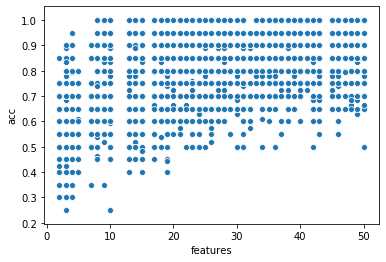

In [24]:
import seaborn as sns

sns.scatterplot(x='features',y='acc',data=CV_df)

In [25]:
CV_df.acc.mean()

0.7994334490740741

In [ ]:
CV_df[CV_df[]]